<a href="https://colab.research.google.com/github/mlsyscourse/public-notebooks/blob/main/08_machine_learning_compilation_tensorir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15-442/15-642: Machine Learning Systems -- Machine Learning Compilation





## Install packages

In the last lecture, we get a high-level overview of machine learning compilation. Today, we will do a deep dive into one tensor program abstraction TensorIR. To get started, let us install the following package.


In [ ]:
!python3 -m  pip install mlc-ai-cu122 -f https://mlc.ai/wheels

Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.2/761.2 MB 2.1 MB/s eta 0:00:00


## Prelude



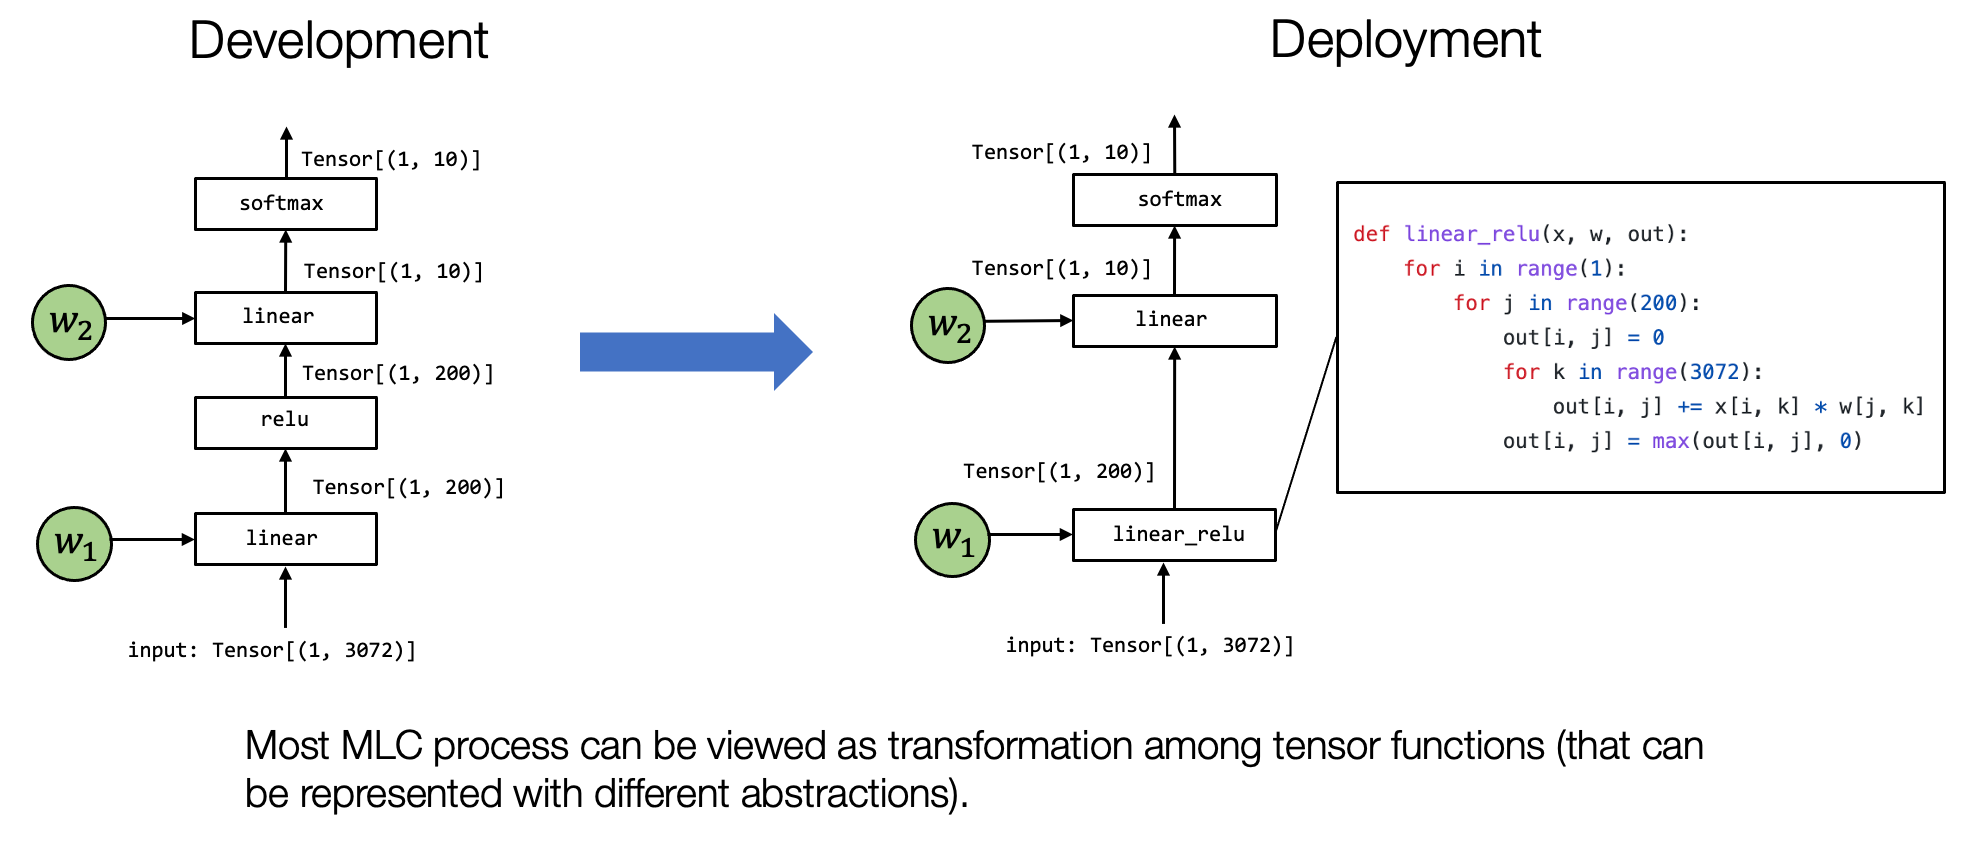

To begin today's lecture, let us recap the key principle of the MLC process. Most of the MLC process can be viewed as transformation among tensor functions. The main thing we aim to answer in our following up are:
- What are the possible abstractions to represent the tensor function.
- What are possible transformations among the tensor functions.

Today we are going to cover part of that by focusing on primitive tensor functions.

## Learning one Tensor Program Abstraction -- TensorIR

We have gone over the primitive tensor function and discussed the high-level idea of tensor program abstractions.

Now we are ready to learn one specific instance of tensor program abstraction called TensorIR. TensorIR is the tensor program abstraction in Apache TVM, which is one of the standard machine learning compilation frameworks.

In [ ]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
import numpy as np

The primary purpose of tensor program abstraction is to represent loops and corresponding hardware acceleration choices such as threading, use of specialized hardware instructions, and memory access.

To help our explanations, let us use the following sequence of tensor computations as a motivating example.

Specifically, for two $128 \times 128 $ matrices A and B, let us perform the following two steps of tensor computations.

- $Y_{ij} = \sum_k A_{ik} B_{kj}$
- $C_{ij} = \mathbb{relu}(Y_{ij}) = \mathbb{max}(Y_{ij}, 0)$

The above computations resemble a typical primitive tensor function commonly seen in neural networks -- a linear layer with relu activation. To begin with, we can implement the two operations using array computations in NumPy as follows.

In [ ]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
# a @ b is equivalent to np.matmul(a, b)
c_mm_relu = np.maximum(a_np @ b_np, 0)

Under the hood, NumPy calls into libraries (such as OpenBLAS) and some of its own implementations in lower-level C languages to execute these computations.

From the tensor program abstraction point of view, we would like to see through the details **under the hood** of these array computations. Specifically, we want to ask: what are the possible ways to implement the corresponding computations?

For the purpose of illustrating details under the hood, we will write examples in a restricted subset of NumPy API -- which we call **low-level numpy** that uses the following conventions:

- We will use a loop instead of array functions when necessary to demonstrate the possible loop computations.
- When possible, we always explicitly allocate arrays via numpy.empty and pass them around.

Note that this is not how one would typically write NumPy programs. Still, they closely resemble what happens under the hood -- most real-world deployment solutions handle allocations separately from computations. The specific libraries perform the computation using different forms of loops and arithmetic computations. Of course, primarily, they are implemented using lower-level languages such as `C.`




In [ ]:
def lnumpy_mm_relu(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j in range(128):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
    for i in range(128):
        for j in range(128):
            C[i, j] = max(Y[i, j], 0)

The program above is one way to implement the `mm_relu` operation. The prorgam contains two stages: first we allocate an intermediate storage $Y$ and store the result of matrix multiplication there. Then we compute the relu in a second sequence of for loops. One thing you might notice is that this is certainly not the only way to implement the `mm_relu`. Likely this is also not the first thing that you might come up with on top of your mind.

Nevertheless, this is one way to implement `mm_relu`, we can verify the correctness of the code by comparing our result to the original one using array computation. We will come back and revisit other possible ways in the later part of this tutorial.

In [ ]:
c_np = np.empty((128, 128), dtype=dtype)
lnumpy_mm_relu(a_np, b_np, c_np)
np.testing.assert_allclose(c_mm_relu, c_np, rtol=1e-5)

The above example code shows how we can bring an **under the hood** implementation of `mm_relu`. Of course, the code itself will run much slower because of the python interpreter. Nevertheless, the example numpy code contains all the possible elements we will use in real-world implementations of those computations.
- Multi-dimensional buffer (arrays).
- Loops over array dimensions.
- Computations statements are executed under the loops.

With the low-level NumPy example in mind, now we are ready to introduce TensorIR. The code block below shows a TensorIR implementation of `mm_relu`. The particular code is implemented in a language called TVMScript, which is a domain-specific dialect embedded in python AST.

In [ ]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def mm_relu(A: T.Buffer((128, 128), "float32"),
                B: T.Buffer((128, 128), "float32"),
                C: T.Buffer((128, 128), "float32")):
        T.func_attr({"global_symbol": "mm_relu", "tir.noalias": True})
        Y = T.alloc_buffer((128, 128), dtype="float32")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                vk = T.axis.reduce(128, k)
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j)
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

It is helpful to be able to see the numpy code and the TensorIR code side-by-side and check the corresponding elements, and we are going to walk through each of them in detail.

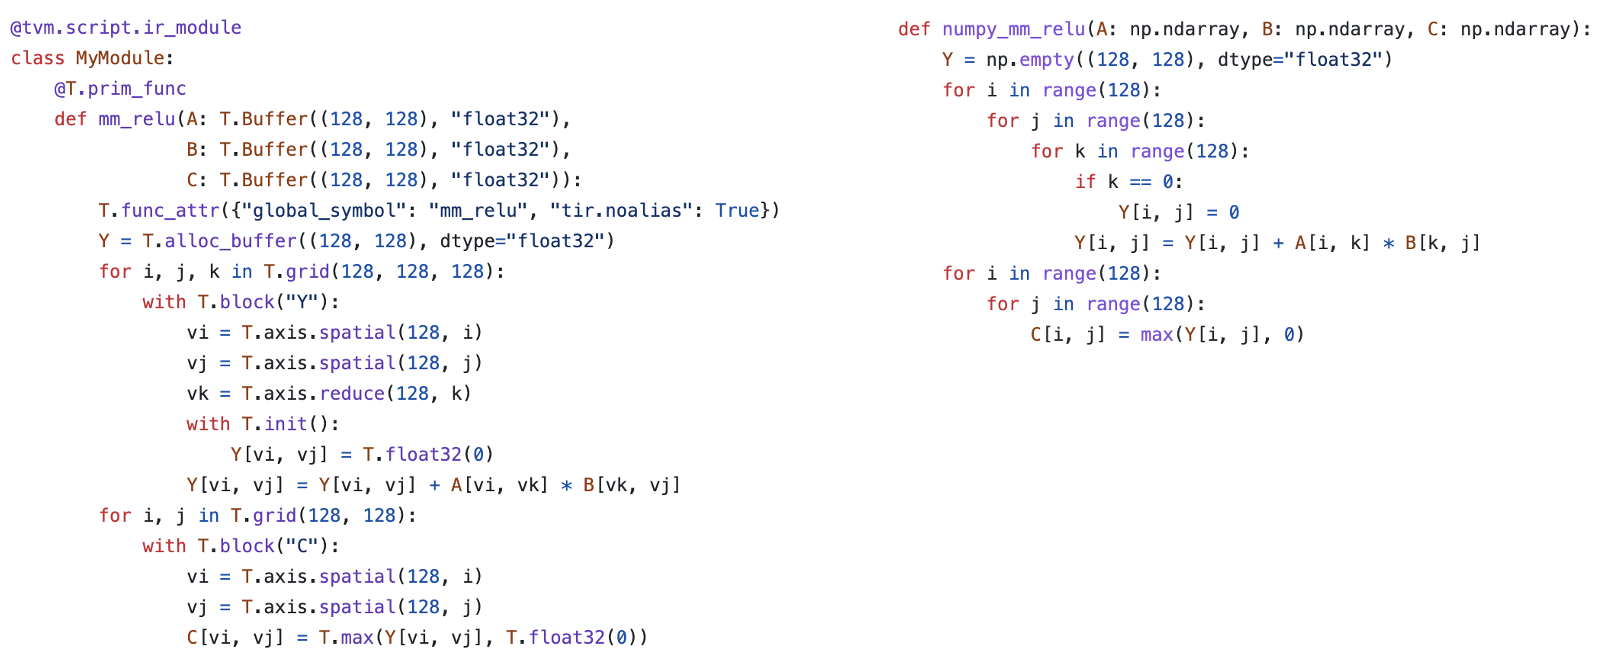

Let us first start by reviewing elements that have a direct correspondence between the numpy and TensorIR side. Then we will come back and review additional elements that are not part of the numpy program.

### Function Parameters and Buffers
First, let us see the function parameters. The function parameters correspond to the same set of parameters on the numpy function.

```python
# TensorIR
def mm_relu(A: T.Buffer((128, 128), "float32"),
            B: T.Buffer((128, 128), "float32"),
            C: T.Buffer((128, 128), "float32")):
    ...
# numpy
def lnumpy_mm_relu(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    ...
```

Here A, B, and C takes a type named `T.Buffer`, which with shape argument `(128, 128)` and data type `float32`. This additional information helps possible MLC process to generate code that specializes in the shape and data type.

Similarly, TensorIR also uses a buffer type in intermediate result allocation.

```python
# TensorIR
Y = T.alloc_buffer((128, 128), dtype="float32")
# numpy
Y = np.empty((128, 128), dtype="float32")
```


### For Loop Iterations

There are also direct correspondence of loop iterations. `T.grid` is a syntactic sugar in TensorIR for us to write multiple nested iterators.


```python
# TensorIR
for i, j, k in T.grid(128, 128, 128):

# numpy
for i in range(128):
    for j in range(128):
        for k in range(128):
```


### Computational Block

One of the main differences comes from the computational statement. TensorIR contains an additional construct called `T.block`.

```python
# TensorIR
with T.block("Y"):
    vi = T.axis.spatial(128, i)
    vj = T.axis.spatial(128, j)
    vk = T.axis.reduce(128, k)
    with T.init():
        Y[vi, vj] = T.float32(0)
    Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
            
# coressponding numpy code
vi, vj, vk = i, j, k
if vk == 0:
    Y[vi, vj] = 0
Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]

```

A **block** is a basic unit of computation in TensorIR. Notably, the block contains a few additional information than the plain NumPy code. A block contains a set of block axes (`vi, vj, vk`) and computations defined around them.

```python
vi = T.axis.spatial(128, i)
vj = T.axis.spatial(128, j)
vk = T.axis.reduce(128, k)
```

The above three lines declare the **key properties** about block axes in the following syntax.
```
[block_axis] = T.axis.[axis_type]([axis_range], [mapped_value])
```

The three lines contain the following information:
- They define where should vi, vj, vk be bound to (in this case i, j k).
- They declare the original range that the vi, vj, vk are supposed to be (the `128` in `T.axis.spatial(128, i)`)
- They declare the properties of the iterators (`spatial`, `reduce`)

Let us walk through those property one by one.  First of all, in terms of the bounding relation. `vi = T.axis.spatial(128, i)` effectively implies `vi = i`. The `[axis_range]` value provided the expected range of the `[block_axis]`. For example,  `128` in `vi = T.axis.spatial(128, i)` provides an indication that `vi` should be in the `range(0, 128)`.



### Block Axis Properties

Let us now start to take a closer look at the block axis properties. These axis properties marks the relation of the axis to the computation being performed.
The figure below summarizes the block (iteration) axes and the read write relations of block Y. Note that strictly speaking the block is doing (reduction) updates to `Y`, we mark this as write for now as we don't need value of `Y` from another block.


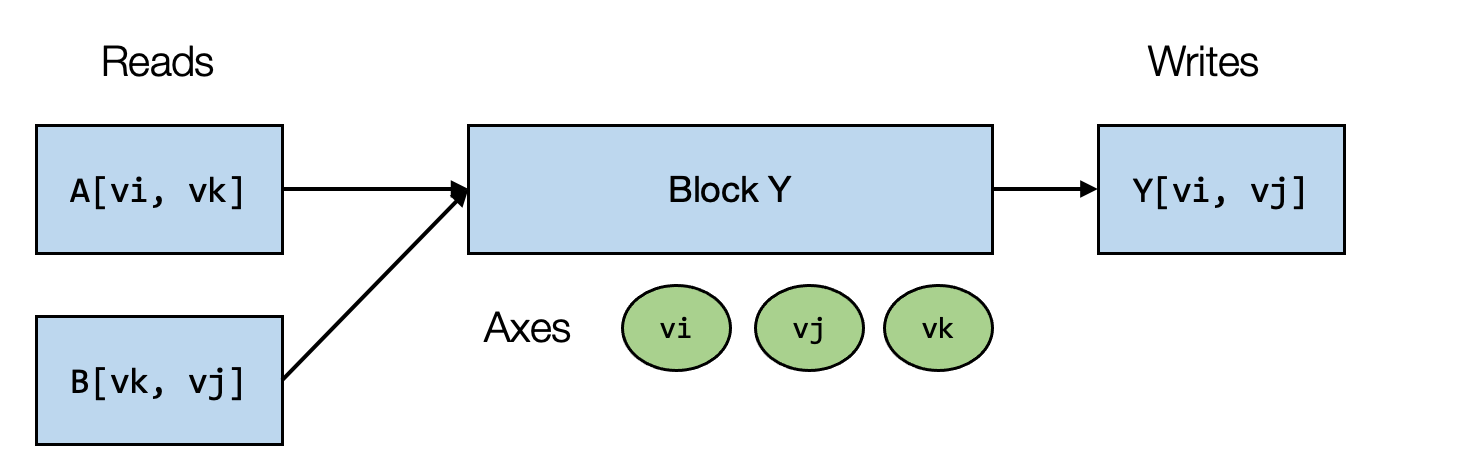


In our example, block Y computes the result `Y[vi, vj]` by reading values from `A[vi, vk]` and `B[vk, vj]` and perform sum over all possible `vk`. In this particular example, if we fix `vi`, `vj` to be `(0, 1)`, and run the block for `vk in range(0, 128)`, we can effectively compute `C[0, 1]` independent from other possible locations (that have different values of vi, vj).


Notably, for a fixed value of vi and vj, the computation block produces a point value at a spatial location of Y (`Y[vi, vj]`) that is independent from other locations in `Y` (with a different `vi, vj` values). we can call `vi`, `vj` **spatial axes** as they directly corresponds to the beginning of a spatial region of buffers that the block writes to. The axes that involves in reduction (`vk`) are named as **reduce axes**.

### Why Extra Information in Block

One crucial observation is that the additional information (block axis range and their properties) makes the block to be **self-contained** when it comes to the iterations that it is supposed to carry out independent from the external loop-nest `i`, `j`, `k`.

The block axis information also provides additional properties that help us to validate the correctness of the external loops that are used to carry out the computation. For example, the above code block will result in an error because the loop expects an iterator of size `128`, but we only bound it to a for loop of size `127`.


```python
# wrong program due to loop and block iteration mismatch
for i in range(127):
    with T.block("C"):
        vi = T.axis.spatial(128, i)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^     
        error here due to iterator size mismatch
        ...
```


This additional information also helps us in following machine learning compilation analysis. For example, while we can always parallelize over spatial axes, parallelizing over reduce axes will require specific strategies.

### Sugars for Block Axes Binding

In situations where each of the block axes is directly mapped to an outer loop iterator, we can use `T.axis.remap` to declare the block axis in a single line.

```python
# SSR means the properties of each axes are "spatial", "spatial", "reduce"
vi, vj, vk = T.axis.remap("SSR", [i, j, k])
```
is equivalent to
```python
vi = T.axis.spatial(range_of_i, i)
vj = T.axis.spatial(range_of_j, j)
vk = T.axis.reduce(range_of_k, k)
```

So we can also write the programs as follows.

In [ ]:
@tvm.script.ir_module
class MyModuleWithAxisRemapSugar:
    @T.prim_func
    def mm_relu(A: T.Buffer((128, 128), "float32"),
                B: T.Buffer((128, 128), "float32"),
                C: T.Buffer((128, 128), "float32")):
        T.func_attr({"global_symbol": "mm_relu", "tir.noalias": True})
        Y = T.alloc_buffer((128, 128), dtype="float32")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]
        for i, j in T.grid(128, 128):
            with T.block("C"):
                vi, vj = T.axis.remap("SS", [i, j])
                C[vi, vj] = T.max(Y[vi, vj], T.float32(0))

### Function Attributes and Decorators

So far, we have covered most of the elements in TensorIR. In this part, we will go over the remaining elements of the script.


The function attribute information contains extra information about the function.
```python
T.func_attr({"global_symbol": "mm_relu", "tir.noalias": True})
```
Here `global_symbol` corresponds to the name of the function, and `tir.noalias` is an attribute indicating that all the buffer memories do not overlap. You also feel free safely skip these attributes for now as they won't affect the overall understanding of the high-level concepts.


The two decorators, `@tvm.script.ir_module` and `@T.prim_func` are used to indicate the type of the corresponding part.



`@tvm.script.ir_module` indicate that MyModule is an `IRModule`. IRModule is the container object to hold a collection of tensor functions in machine learning compilation.

In [ ]:
type(MyModule)

tvm.ir.module.IRModule

`@T.prim_func` indicates that the particular function `mm_relu` is a PrimFunc (which stands for primitive tensor function).

In [ ]:
type(MyModule["mm_relu"])

tvm.tir.function.PrimFunc

Up until now, we have only seen IRModules containing a single tensor function. An IRModule in the MLC process can contain multiple tensor functions. The following code block shows an example of an IRModule with two functions.

In [ ]:
@tvm.script.ir_module
class MyModuleWithTwoFunctions:
    @T.prim_func
    def mm(A: T.Buffer((128, 128), "float32"),
           B: T.Buffer((128, 128), "float32"),
           Y: T.Buffer((128, 128), "float32")):
        T.func_attr({"global_symbol": "mm", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + A[vi, vk] * B[vk, vj]

    @T.prim_func
    def relu(A: T.Buffer((128, 128), "float32"),
             B: T.Buffer((128, 128), "float32")):
        T.func_attr({"global_symbol": "relu", "tir.noalias": True})
        for i, j in T.grid(128, 128):
            with T.block("B"):
                vi, vj = T.axis.remap("SS", [i, j])
                B[vi, vj] = T.max(A[vi, vj], T.float32(0))

### Section Checkpoint

So far, we have gone through one example instance of TensorIR program and covered most of the elements, including:
- Buffer declarations in parameters and intermediate temporary memory.
- For loop iterations.
- **Block** and block axes properties.

In this section, we have gone through one example instance of TensorIR that covers the most common elements in MLC.

TensorIR contains more elements than what we went over in this section, but this section covers most of the key parts that can get us started in the MLC journey. We will cover new elements as we encounter them in the later chapters.

## Transformation

In the last section, we learned about TensorIR and its key elements. Now, let us get to the main ingredients of all MLC flows -- transformations of primitive tensor functions.

In the last section, we have given an example of how to write `mm_relu` using low-level numpy. In practice, there can be multiple ways to implement the same functionality, and each implementation can result in different performance.

We will discuss the reason behind the performance and how to leverage those variants in future lectures. In this lecture, let us focus on the ability to get different implementation variants using transformations.


In [ ]:
def lnumpy_mm_relu_v2(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j0 in range(32):
            for k in range(128):
                for j1 in range(4):
                    j = j0 * 4 + j1
                    if k == 0:
                        Y[i, j] = 0
                    Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
    for i in range(128):
        for j in range(128):
            C[i, j] = max(Y[i, j], 0)

c_np = np.empty((128, 128), dtype=dtype)
lnumpy_mm_relu_v2(a_np, b_np, c_np)
np.testing.assert_allclose(c_mm_relu, c_np, rtol=1e-5)

The above code block shows a slightly different variation of `mm_relu`. To see the relation to the original program
- We replace the `j` loop with two loops, `j0` and `j1`.
- The order of iterations changes slightly

In order to get `lnumpy_mm_relu_v2`, we have to rewrite a new function (or manual copy-pasting and editing). TensorIR introduces a utility called Schedule that allows us to do that pragmatically.

To remind ourselves, let us look again at the current MyModule content. We use `mod.show()` to get a highlighted string based representation of the IRModule.

In [ ]:
MyModule.show()

Now we are ready to try out the code transformations, we begin by creating a `Schedule` helper class with the given MyModule as input.

In [ ]:
sch = tvm.tir.Schedule(MyModule)

Then we perform the following operations to obtain a reference to block Y and corresponding loops.

In [ ]:
block_Y = sch.get_block("Y", func_name="mm_relu")
i, j, k = sch.get_loops(block_Y)


Now we are ready to perform the transformations. The first transformation we will perform is to split the loop `j` into two loops, with the length of the inner loop to be `4`. Note that the transformation is procedural, so if you accidentally execute the block twice, we will get an error that variable `j` no longer exists. If that happens, you can run again from the beginning (where `sch` get created).


In [ ]:
j0, j1 = sch.split(j, factors=[None, 4])

We can look at the result of the transformation, which is stored at `sch.mod`.

In [ ]:
sch.mod.show()

After the first step of transformation, we created two additional loops, `j_0` and `j_1`, with corresponding ranges 32 and 4.  Our next step would be to reorder the two loops.

In [ ]:
sch.reorder(j0, k, j1)
sch.mod.show()

In [ ]:
def lnumpy_mm_relu_v2(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j0 in range(32):
            for k in range(128):
                for j1 in range(4):
                    j = j0 * 4 + j1
                    if k == 0:
                        Y[i, j] = 0
                    Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
    for i in range(128):
        for j in range(128):
            C[i, j] = max(Y[i, j], 0)

Now code after reordering closely resembles `lnumpy_mm_relu_v2`.

### Getting to Another Variant

In this section, we are going to go ahead and do another two steps of transformations to get to another variant. First, we use a primitive called
`reverse_compute_at` to move block C to an inner loop of `Y`.

In [ ]:
block_C = sch.get_block("C", "mm_relu")
sch.reverse_compute_at(block_C, j0)
sch.mod.show()


So far, we have kept the reduction initialization and update step together in a single block body. This combined form brings convenience for loop transformations (as outer loop i,j of initialization and updates usually need to keep in sync with each other).

After loop transformations, we can move the initialization of `Y`'s element separate from the reduction update. We can do that through the `decompose_reduction`  primitive. (note: this is also done implicitly by tvm during future compilation, so this step is mainly to make it explicit and see the end effect).

In [ ]:
block_Y = sch.get_block("Y", "mm_relu")
sch.decompose_reduction(block_Y, k)
sch.mod.show()

The final transformed code resembles the following low-level NumPy code.

In [ ]:
def lnumpy_mm_relu_v3(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    Y = np.empty((128, 128), dtype="float32")
    for i in range(128):
        for j0 in range(32):
            # Y_init
            for j1 in range(4):
                j = j0 * 4 + j1
                Y[i, j] = 0
            # Y_update
            for k in range(128):
                for j1 in range(4):
                    j = j0 * 4 + j1
                    Y[i, j] = Y[i, j] + A[i, k] * B[k, j]
            # C
            for j1 in range(4):
                j = j0 * 4 + j1
                C[i, j] = max(Y[i, j], 0)

c_np = np.empty((128, 128), dtype=dtype)
lnumpy_mm_relu_v3(a_np, b_np, c_np)
np.testing.assert_allclose(c_mm_relu, c_np, rtol=1e-5)

### Section Summary and Discussions

The main takeaway of this section is to get used to the paradigm of incremental code transformations. In our particular example, we use `tir.Schedule` as an auxiliary helper object.

Importantly, we avoided the need to re-create different variants of the same program (`lnumpy_mm_relu`, `lnumpy_mm_relu_v2` and `lnumpy_mm_relu_v3`).  The additional information in blocks (axes information) is the reason we can do such transformations under the hood.

## Build and Run

So far, we have only looked at the script output of the transformed result. We can also run the program obtained in IRModule.

First, we call a build function to turn an IRModule into a `runtime.Module`, representing a collection of runnable functions. Here target specifies detailed information about the deployment environment. For this particular case, we will use `llvm`, which helps us compile to the native CPU platform.

When we target different platforms(e.g. an Android phone) or platforms with special instructions (intel skylake), we will need to adjust the target accordingly. We will discuss different target choices as we start to deploy to those environments.

In [ ]:
rt_lib = tvm.build(MyModule, target="llvm")

Then, we will create three tvm ndarrays that are used to hold inputs and the output.

In [ ]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")
type(c_nd)

tvm.runtime.ndarray.NDArray

Finally, we can get the runnable function from rt_lib and execute it by passing the three array arguments. We can further run validation to check the code difference.

In [ ]:
func_mm_relu = rt_lib["mm_relu"]
func_mm_relu(a_nd, b_nd, c_nd)

np.testing.assert_allclose(c_mm_relu, c_nd.numpy(), rtol=1e-5)

We have built and run the original MyModule. We can also build the transformed program

In [ ]:
rt_lib_after = tvm.build(sch.mod, target="llvm")
rt_lib_after["mm_relu"](a_nd, b_nd, c_nd)
np.testing.assert_allclose(c_mm_relu, c_nd.numpy(), rtol=1e-5)

Finally, we can compare the time difference between the two. `time_evaluator` is a helper benchmarking function that can be used to compare the running performance of different generated functions.

In [ ]:
f_timer_before = rt_lib.time_evaluator("mm_relu", tvm.cpu())
print("Time cost of MyModule %g sec" % f_timer_before(a_nd, b_nd, c_nd).mean)
f_timer_after = rt_lib_after.time_evaluator("mm_relu", tvm.cpu())
print("Time cost of transformed sch.mod %g sec" % f_timer_after(a_nd, b_nd, c_nd).mean)

Time cost of MyModule 0.00267919 sec
Time cost of transformed sch.mod 0.000757564 sec


It is interesting to see the running time difference between the two codes. Let us do a quick analysis of what are the possible factors that affect the performance.  First, let us remind ourselves of two variants of the code.

In [ ]:
MyModule.show()

In [ ]:
sch.mod.show()

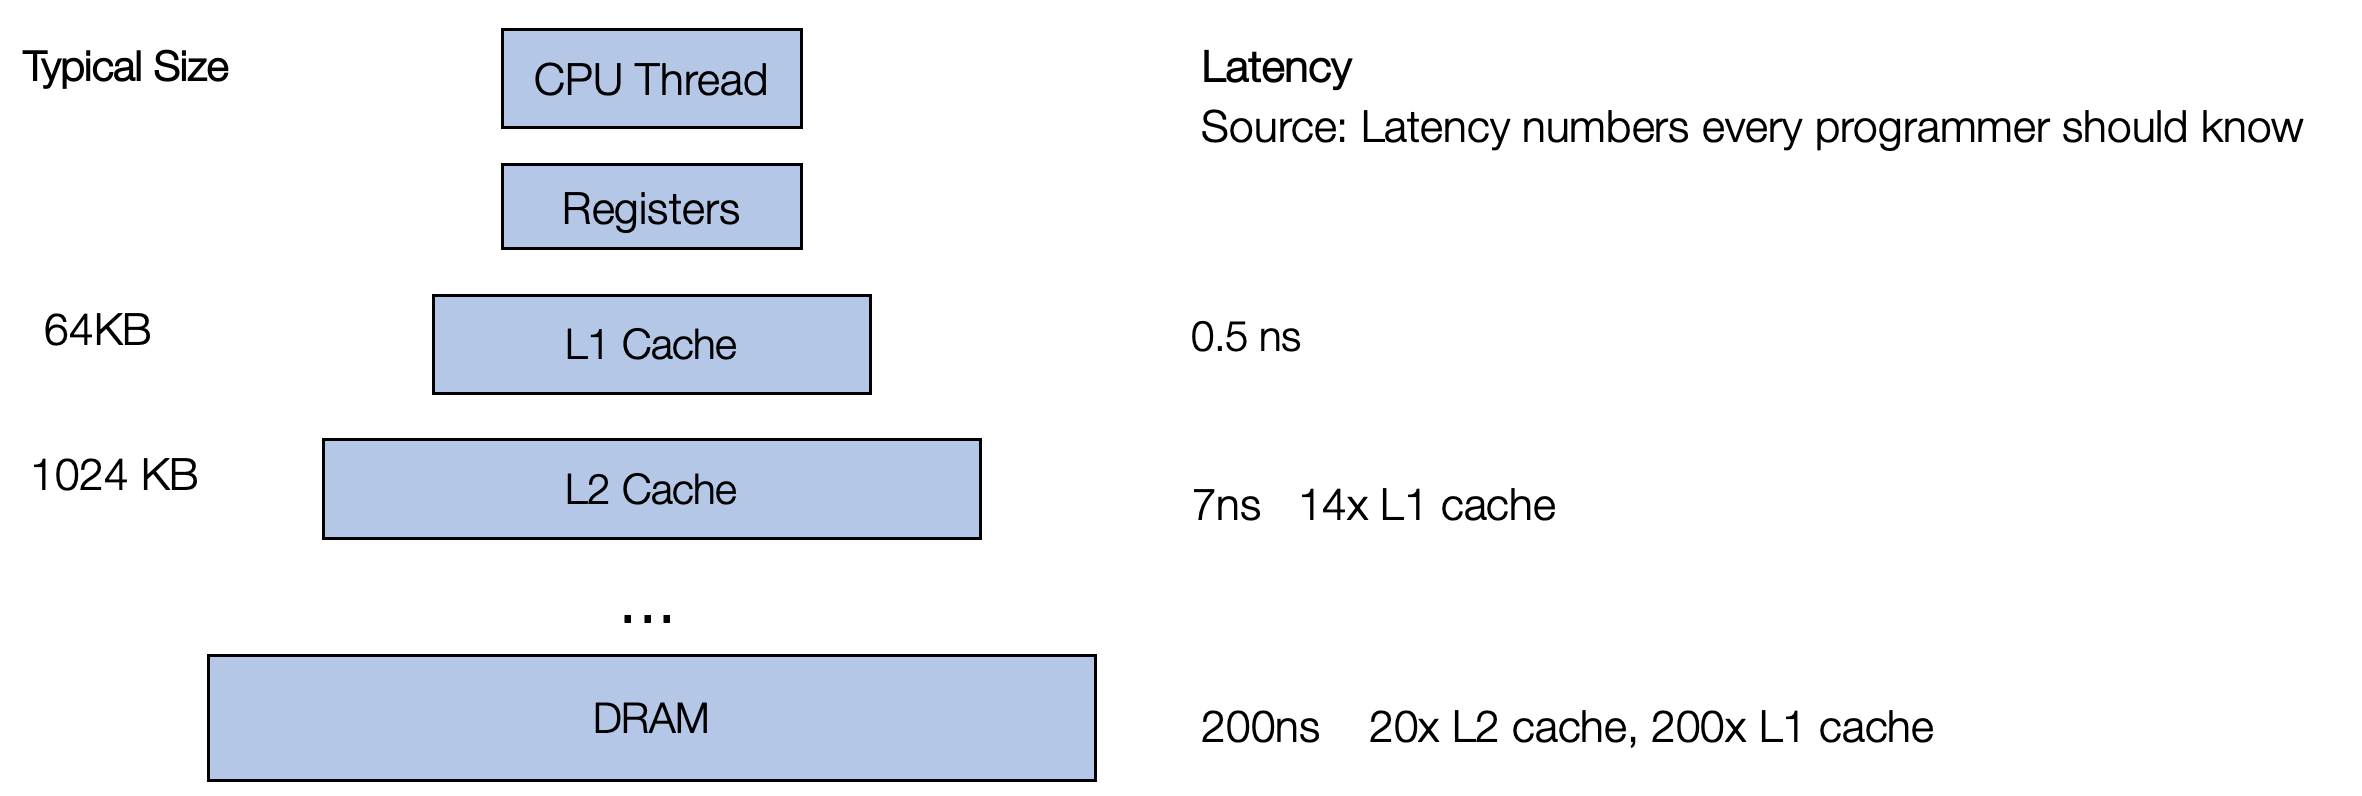

To see why different loop variants result in different performances, we need to review the fact that it is not uniformly fast to access any piece of memory in `A` and `B`. Modern CPU comes with multiple levels of caches, where data needs to be fetched into the cache before the CPU can access it.

Importantly, it is much faster to access the data already in the cache. One strategy that CPU takes is to fetch data closer to each other. When we read one element in the memory, it will attempt to fetch the elements close by (formally known as cache-line) to the cache. So when you read the next element, it is already in the cache. As a result, code with continuous memory access is usually faster than code that randomly accesses different parts of the memory.

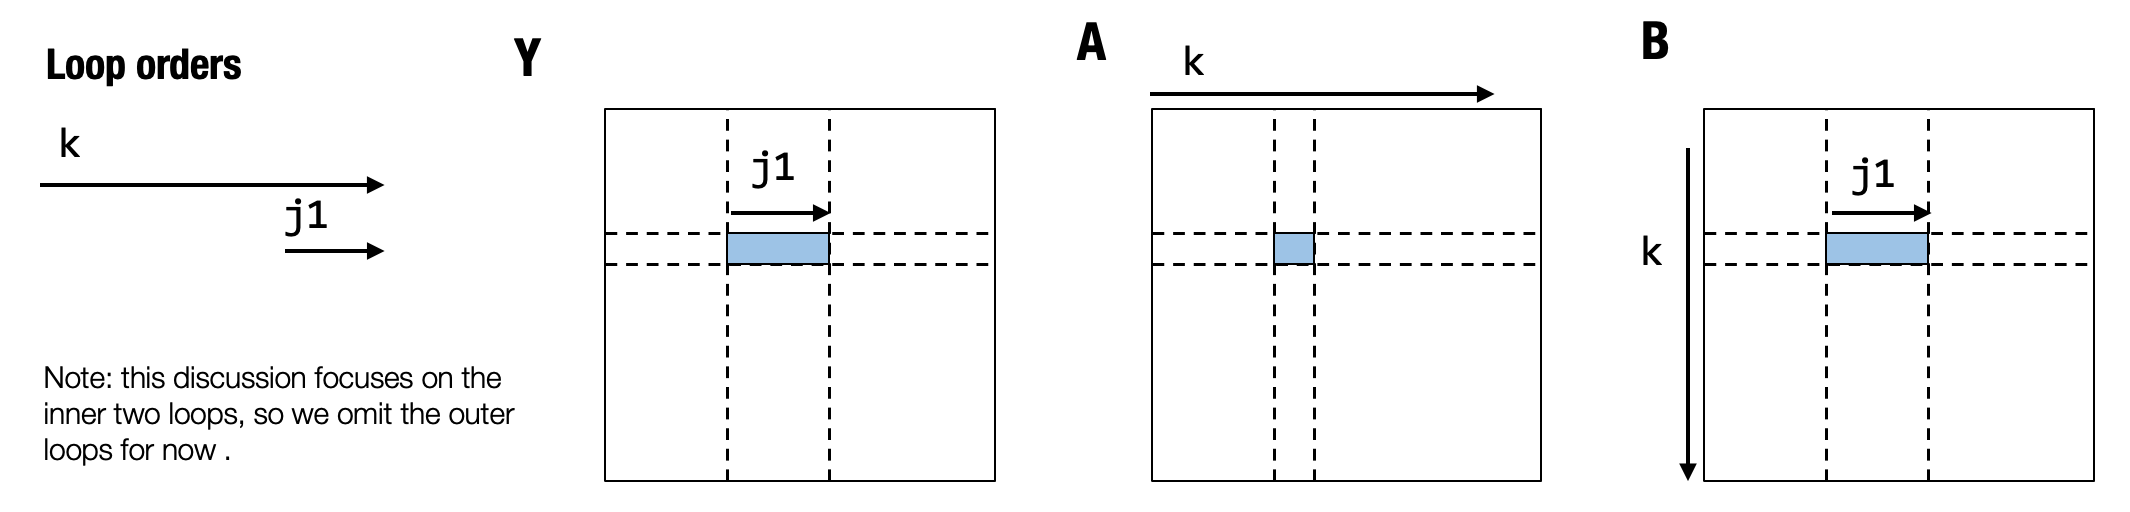

Now let us look at the above visualization of iterations and analyze what is going on.
In this analysis, let us focus on two inner-most loops: `k` and `j1`. The highlighted cover shows the corresponding region in `Y`, `A` and `B` that the iteration touches when we iterate over `j1` for one specific instance of `k`.

We can find that the `j1` iteration produces **continuous access** to elements of `B`. Specifically, it means the values we read when `j1=0` and `j1=1` are next to each other. This enables better cache access behavior. In addition, we bring the computation of C closer to `Y`, enabling better caching behavior.

Our current example is mainly to demonstrate that different variants of code can lead to different performances. More transformation steps can help us to get to even better performance, which we will cover in future chapters. The main goal of this exercise is first to get us the tool of program transformations and first taste of what is possible through transformations.



### Excercise
As an exercise, try different jfactor choices and see how they affect the code's performance.

In [ ]:
def transform(mod, jfactor):
    sch = tvm.tir.Schedule(mod)
    block_Y = sch.get_block("Y", func_name="mm_relu")
    i, j, k = sch.get_loops(block_Y)
    j0, j1 = sch.split(j, factors=[None, jfactor])
    sch.reorder(j0, k, j1)
    block_C = sch.get_block("C", "mm_relu")
    sch.reverse_compute_at(block_C, j0)
    return sch.mod

mod_transformed = transform(MyModule, jfactor=8)

rt_lib_transformed = tvm.build(mod_transformed, "llvm")
f_timer_transformed = rt_lib_transformed.time_evaluator("mm_relu", tvm.cpu())
print("Time cost of transformed mod_transformed %g sec" % f_timer_transformed(a_nd, b_nd, c_nd).mean)
# display the code below
mod_transformed.show()

Time cost of transformed mod_transformed 0.000366125 sec


## Running on GPU

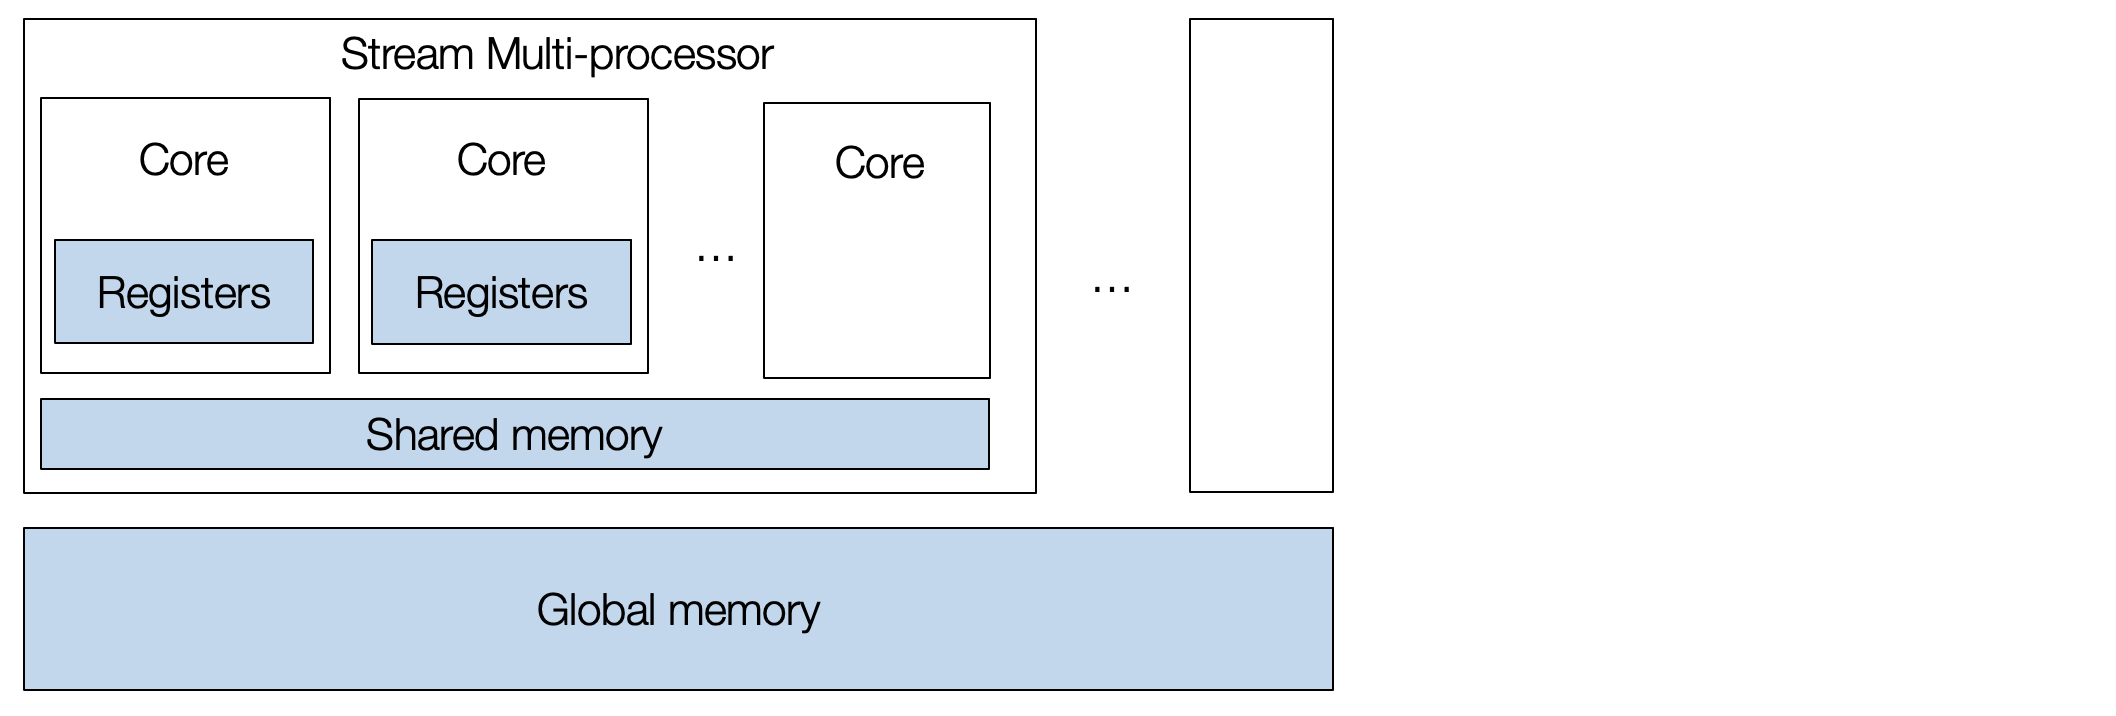

To program a GPU, we need to create a set of thread blocks, with each thread mapping to the cores and the thread block map to the stream multiprocessors.

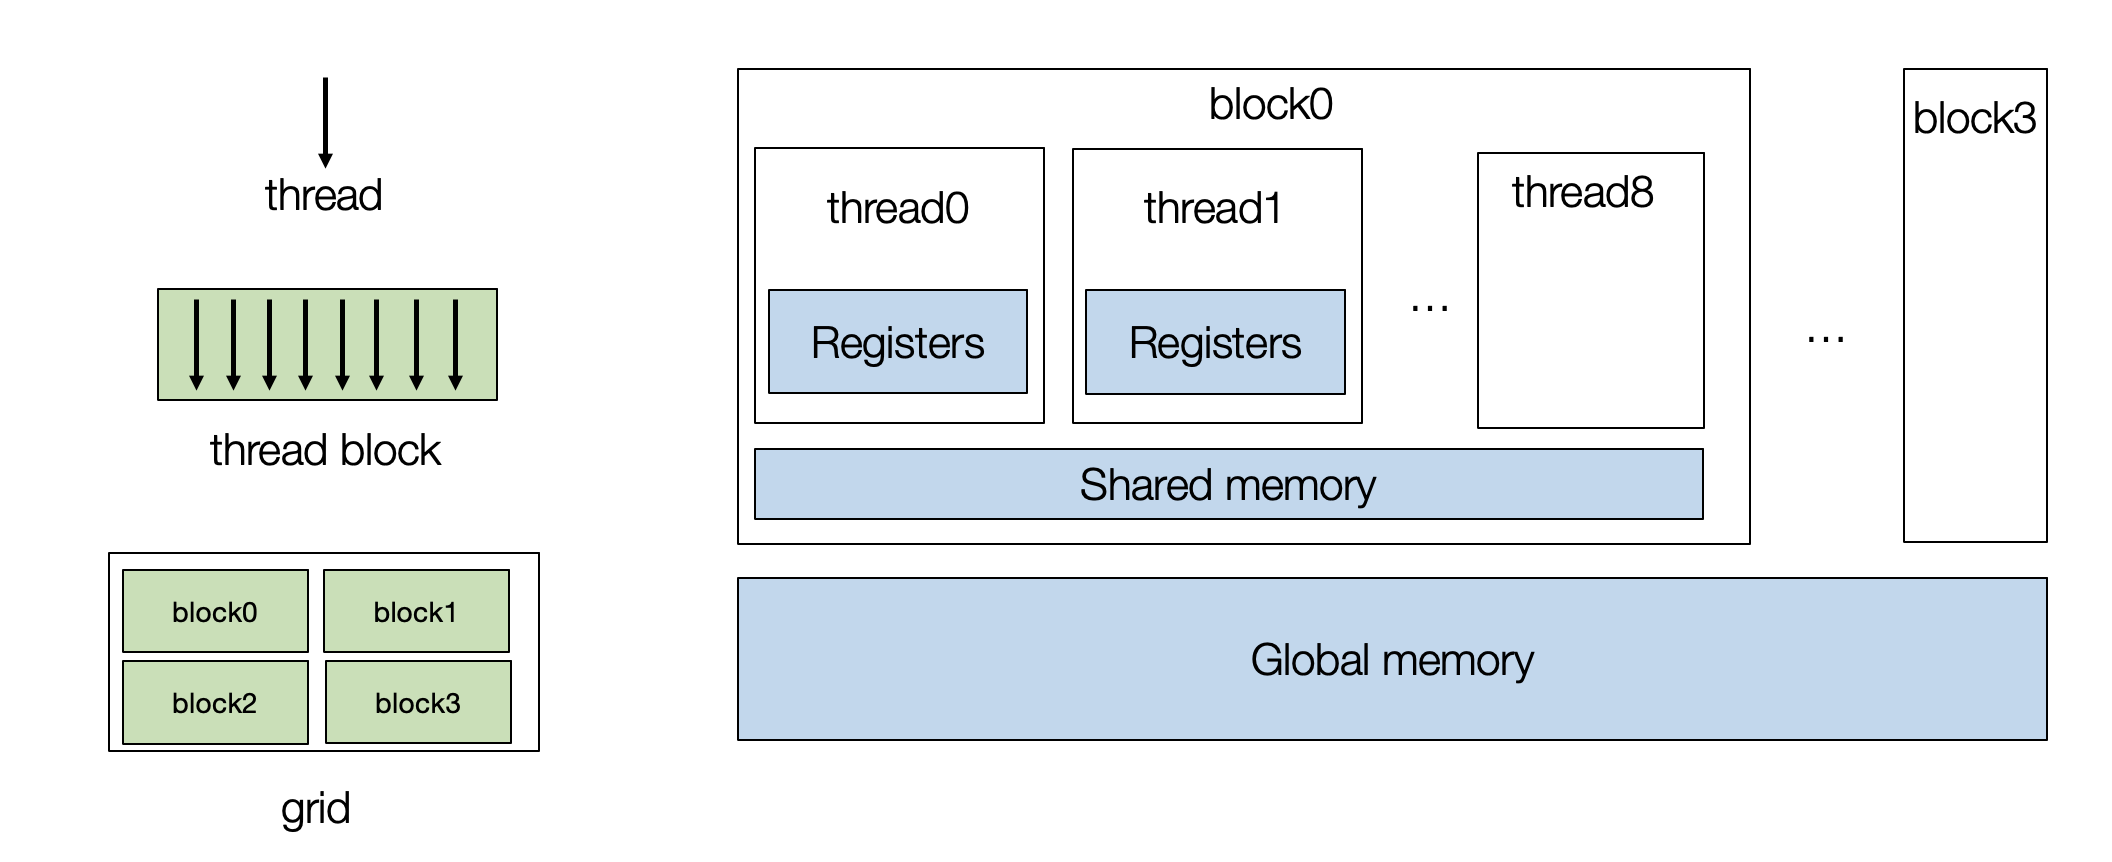

Let us start GPU programming using a vector add example. The following TensorIR program takes two vectors, A and B, performs element-wise add, and stores the result in C.

In [ ]:
@tvm.script.ir_module
class MyModuleVecAdd:
    @T.prim_func
    def main(A: T.Buffer((1024,), "float32"),
             B: T.Buffer((1024,), "float32"),
             C: T.Buffer((1024,), "float32")) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i in T.grid(1024):
            with T.block("C"):
                vi = T.axis.remap("S", [i])
                C[vi] = A[vi] + B[vi]

We first split loop `i` into two loops.

In [ ]:
sch = tvm.tir.Schedule(MyModuleVecAdd)
block_C = sch.get_block("C")
i, = sch.get_loops(block=block_C)
i0, i1 = sch.split(i, [None, 128])
sch.mod.show()

### GPU Thread Blocks

Then we bind the iterators to the GPU thread blocks. Each thread is parameterized by two indices -- `threadIdx.x` and `blockIdx.x`. In practice, we can have multiple dimensional thread indices, but we keep them simple as one dimension.

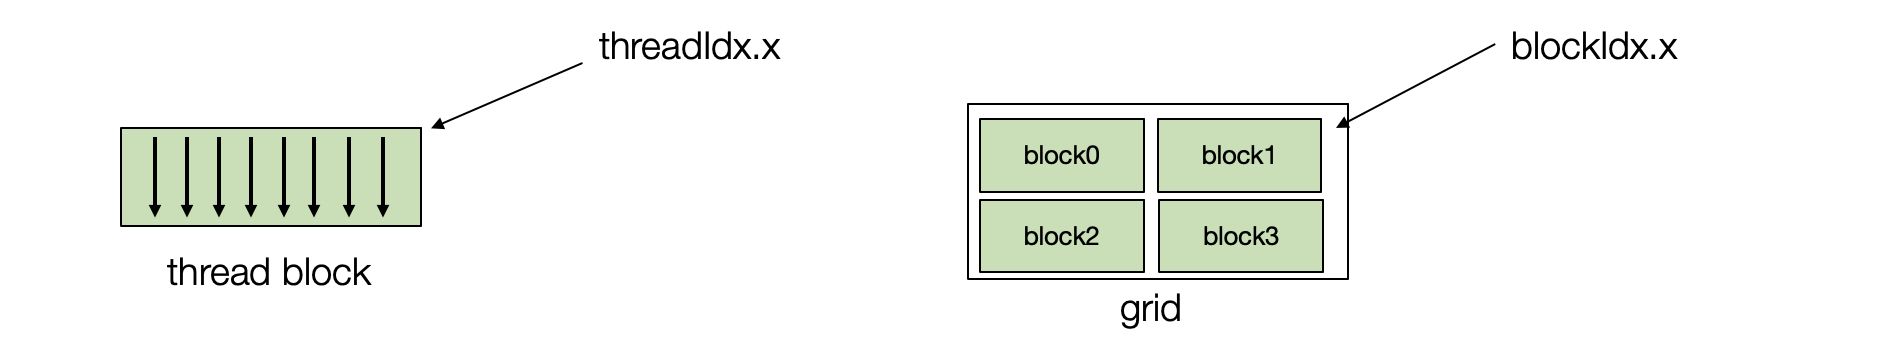

In [ ]:
sch.bind(i0, "blockIdx.x")
sch.bind(i1, "threadIdx.x")
sch.mod.show()

### Build and Run the TensorIR Function on GPU

We can build and test out the resulting function on the GPU.

In [ ]:
rt_mod = tvm.build(sch.mod, target="cuda")

A_np = np.random.uniform(size=(1024,)).astype("float32")
B_np = np.random.uniform(size=(1024,)).astype("float32")
A_nd = tvm.nd.array(A_np, tvm.cuda(0))
B_nd = tvm.nd.array(B_np, tvm.cuda(0))
C_nd = tvm.nd.array(np.zeros((1024,), dtype="float32"), tvm.cuda(0))

rt_mod["main"](A_nd, B_nd, C_nd)
print(A_nd)
print(B_nd)
print(C_nd)

[0.6084427  0.17951351 0.02606347 ... 0.49530572 0.60670066 0.33586136]
[0.37533462 0.1309671  0.4037871  ... 0.06182072 0.46771178 0.43747076]
[0.98377734 0.3104806  0.42985058 ... 0.5571264  1.0744125  0.7733321 ]


In [ ]:
np.testing.assert_allclose(C_nd.numpy(), A_np + B_np)

## Window Sum Example

Now, let us move forward to another example -- window sum. This program can be viewed as a basic version of "convolution" with a predefined weight `[1,1,1]`. We are taking sliding over the input and add three neighboring values together.

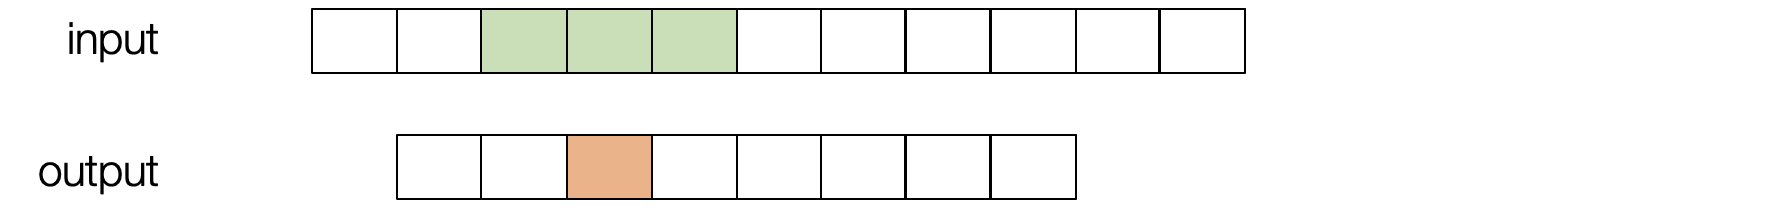

In [ ]:
@tvm.script.ir_module
class MyModuleWindowSum:
    @T.prim_func
    def main(A: T.Buffer((1027,), "float32"),
             B: T.Buffer((1024,), "float32")) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i in T.grid(1024):
            with T.block("C"):
                vi = T.axis.remap("S", [i])
                B[vi] = A[vi] + A[vi + 1] + A[vi + 2]

First, we can bind the loop to GPU threads.

In [ ]:
sch = tvm.tir.Schedule(MyModuleWindowSum)
nthread = 128
block_C = sch.get_block("C")
i,  = sch.get_loops(block=block_C)
i0, i1 = sch.split(i, [None, nthread])
sch.bind(i0, "blockIdx.x")
sch.bind(i1, "threadIdx.x")
sch.mod.show()

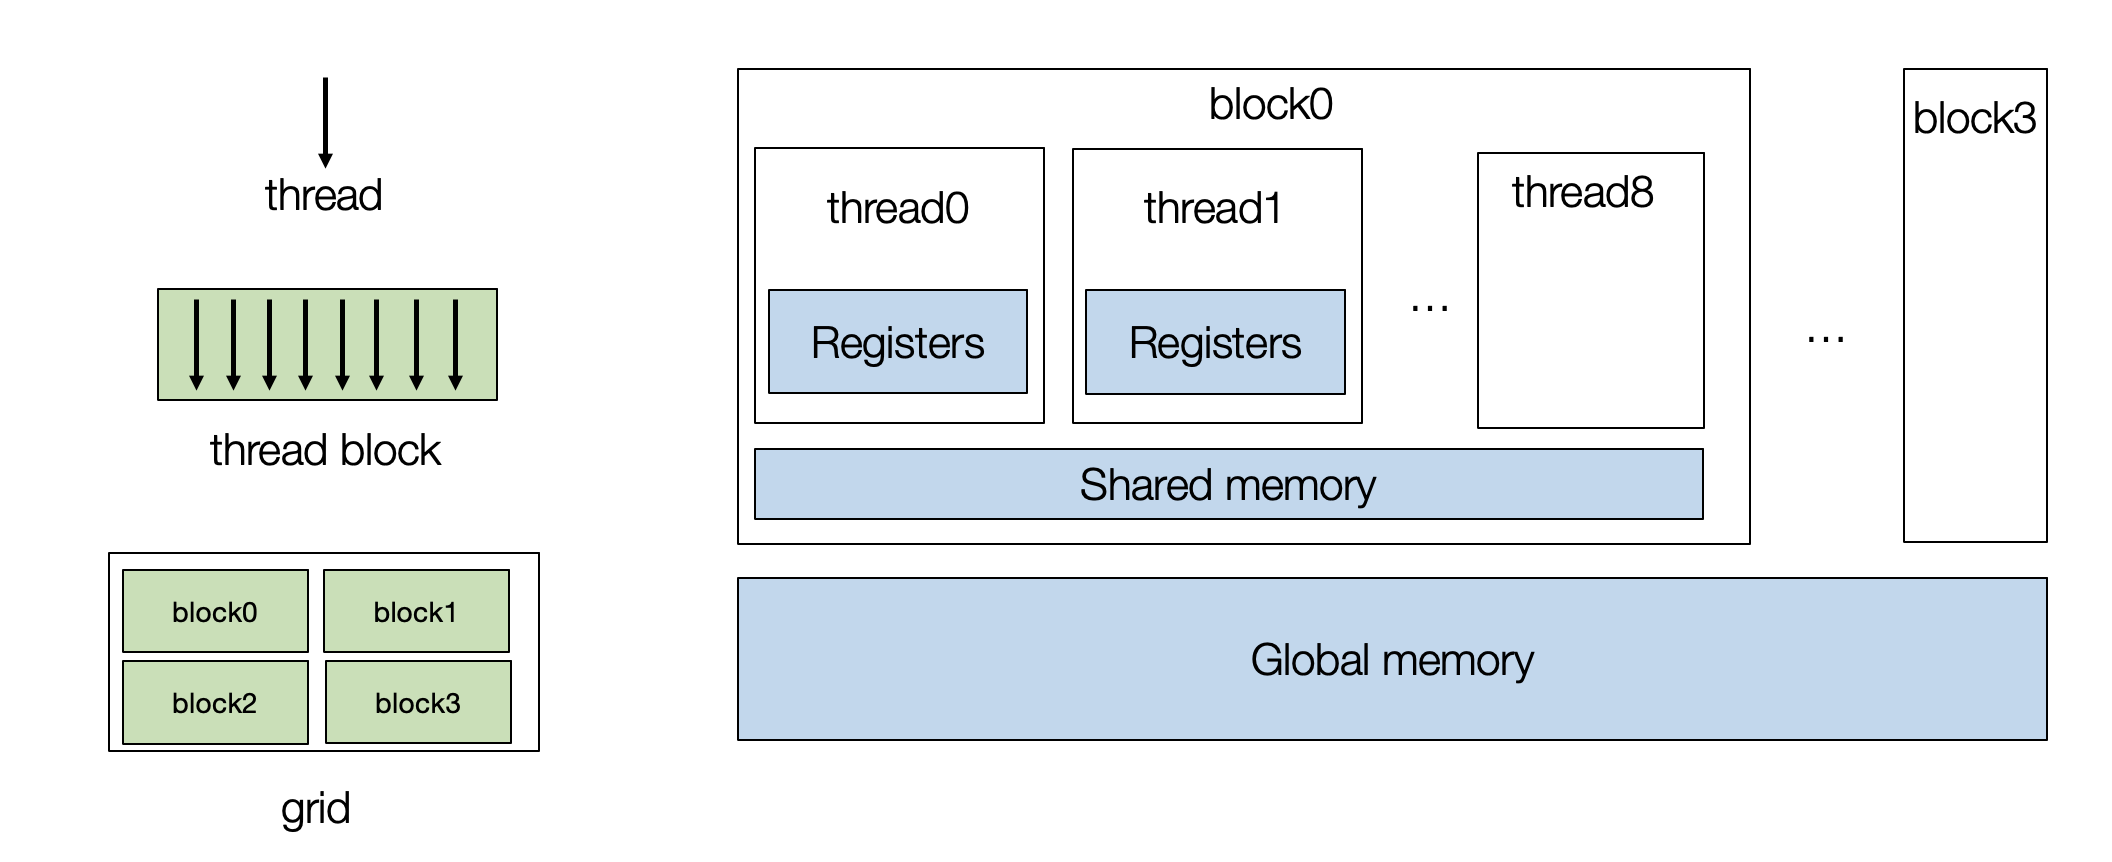

Importantly, in this case, there are reuse opportunities. Remember that each GPU thread block contains shared memory that all threads can access within the block. We use `cache_read` to add an intermediate stage that caches segments (in green below) onto the shared memory. After the caching is finished, the threads can then read from the shared memory.

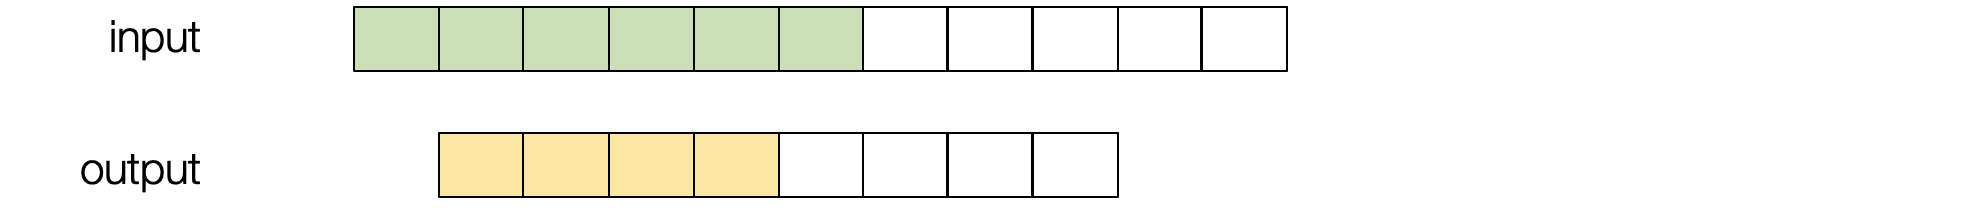

In [ ]:
A_shared = sch.cache_read(block_C, read_buffer_index=0, storage_scope="shared")
sch.compute_at(A_shared, i1)
sch.mod.show()

Because the memory is shared across threads, we need to resplit the loop and bind the inner iterator of the fetching process onto the thread indices. This technique is called **cooperative fetching**, where multiple threads work together to bring the data onto the shared memory. The following reading process can be different.

In [ ]:
ax = sch.get_loops(A_shared)[-1]
ax0, ax1 = sch.split(ax, [None, nthread])
sch.bind(ax1, "threadIdx.x")
sch.mod.show()

We can inspect the corresponding low-level code (in CUDA). The generated code contains two parts:
- A host part that calls into the GPU driver
- A cuda kernel that runs the corresponding computation.

We can print out the cuda kernel using the following code. We still need both the host and kernel code to run the program, so it is only a quick way to inspect what the final code generation result.

Notably, the build process automatically compacts the shared memory stage to use a minimum region used within the thread block.

In [ ]:
rt_mod = tvm.build(sch.mod, target="cuda")
print(rt_mod.imported_modules[0].get_source())


#if (((__CUDACC_VER_MAJOR__ == 11) && (__CUDACC_VER_MINOR__ >= 4)) || \
     (__CUDACC_VER_MAJOR__ > 11))
#define TVM_ENABLE_L2_PREFETCH 1
#else
#define TVM_ENABLE_L2_PREFETCH 0
#endif

#ifdef _WIN32
  using uint = unsigned int;
  using uchar = unsigned char;
  using ushort = unsigned short;
  using int64_t = long long;
  using uint64_t = unsigned long long;
#else
  #define uint unsigned int
  #define uchar unsigned char
  #define ushort unsigned short
  #define int64_t long long
  #define uint64_t unsigned long long
#endif
extern "C" __global__ void __launch_bounds__(128) main_kernel(float* __restrict__ A, float* __restrict__ B);
extern "C" __global__ void __launch_bounds__(128) main_kernel(float* __restrict__ A, float* __restrict__ B) {
  __shared__ float A_shared[130];
  for (int ax0_0 = 0; ax0_0 < 2; ++ax0_0) {
    if (((ax0_0 * 64) + (((int)threadIdx.x) >> 1)) < 65) {
      A_shared[((ax0_0 * 128) + ((int)threadIdx.x))] = A[(((((int)blockIdx.x) * 128) + (ax0_0 * 128)) + ((int)thr

### Build Code for Other GPU Platforms

A MLC process usually support targeting multiple kinds of hardware platforms, we can generate opencl code(which is another kind of GPU programming model) by changing the target parameter.

In [ ]:
rt_mod = tvm.build(sch.mod, target="metal")
print(rt_mod.imported_modules[0].get_source())

// Function: main_kernel0
#include <metal_stdlib>
using namespace metal;

union __TVMArgUnion {
 int v_int[2];
};

kernel void main_kernel0(  device float* A [[ buffer(0) ]],
  device float* B [[ buffer(1) ]],
  uint blockIdx [[threadgroup_position_in_grid]],
  uint threadIdx [[thread_position_in_threadgroup]]
) {
  threadgroup float A_shared[130];
  for (int ax0_0 = 0; ax0_0 < 2; ++ax0_0) {
    if (((ax0_0 * 64) + (((int)threadIdx) >> 1)) < 65) {
      A_shared[((ax0_0 * 128) + ((int)threadIdx))] = A[(((((int)blockIdx) * 128) + (ax0_0 * 128)) + ((int)threadIdx))];
    }
  }
  threadgroup_barrier(mem_flags::mem_threadgroup);
  B[((((int)blockIdx) * 128) + ((int)threadIdx))] = ((A_shared[((int)threadIdx)] + A_shared[(((int)threadIdx) + 1)]) + A_shared[(((int)threadIdx) + 2)]);
}




## Extra content: Ways to Create and Interact with TensorIR

In the last sections, we learned about TensorIR abstraction and ways to transform things. TensorIR comes with an additional construct named block that helps us analyze and perform code transformations. One natural question we might ask: what are common ways to create and interact with TensorIR functions?

### Create TensorIR via TVMScript

The first way to get a TensorIR function is to write a function in TVMScript directly, and this is also the approach we use in the last sections. TVMScript also allows us to skip certain parts of information when necessary. For example, `T.axis.remap` enables us to shorten the iterator size annotations.

TVMScript is also a useful way to inspect the tensor functions in the middle of transformations. In some instances, it might be helpful to print out the script, do some manual editing, then feed it back to the MLC process just to debug and try out possible transformation (manually), then bake it into the MLC process.

### Generate TensorIR code using Tensor Expression

In many cases, our development forms are higher-level abstractions that are not at the loop level. So another common way to obtain TensorIR is pragmatically generating relevant code.

Tensor expression (te) is a domain-specific language that describes a sequence of computations via an expression like API.

In [ ]:
from tvm import te
A = te.placeholder((128, 128), "float32", name="A")
B = te.placeholder((128, 128), "float32", name="B")
k = te.reduce_axis((0, 128), "k")
Y = te.compute((128, 128), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="Y")
C = te.compute((128, 128), lambda i, j: te.max(Y[i, j], 0), name="C")

Here `te.compute` takes the signature `te.compute(output_shape, fcompute)`.
And the fcompute function describes how we want to compute the value of each element `Y[i, j]` for a given index.

```python
lambda i, j: te.sum(A[i, k] * B[k, j], axis=k)
```

The above lambda expression describes the computation $Y_{ij} = \sum_k A_{ik} B_{kj}$. After describing the computation, we can create a TensorIR function by passing the relevant parameter we are interested in. In this particular case, we want to create a function with two input parameters (A, B) and one output parameter (C).



In [ ]:
te_func = te.create_prim_func([A, B, C]).with_attr({"global_symbol": "mm_relu"})
MyModuleFromTE = tvm.IRModule({"mm_relu": te_func})
MyModuleFromTE.show()

The tensor expression API provides a helpful tool to generate TensorIR functions for a given higher-level input.

## TensorIR Functions as Result of Transformations

In practice, we also get TensorIR functions as results of transformations. This happens when we start with two primitive tensor functions (mm and relu), then apply a pragmatic transformation to "fuse" them into a single primitive tensor function, ` mm_relu`. We will cover the details in future chapters.




## Discussions

Let us review what we learned so far. We learned that a common MLC process follows a sequence of program transformations. It is interesting to compare the TensorIR transformation process to the low-level numpy reference development process.

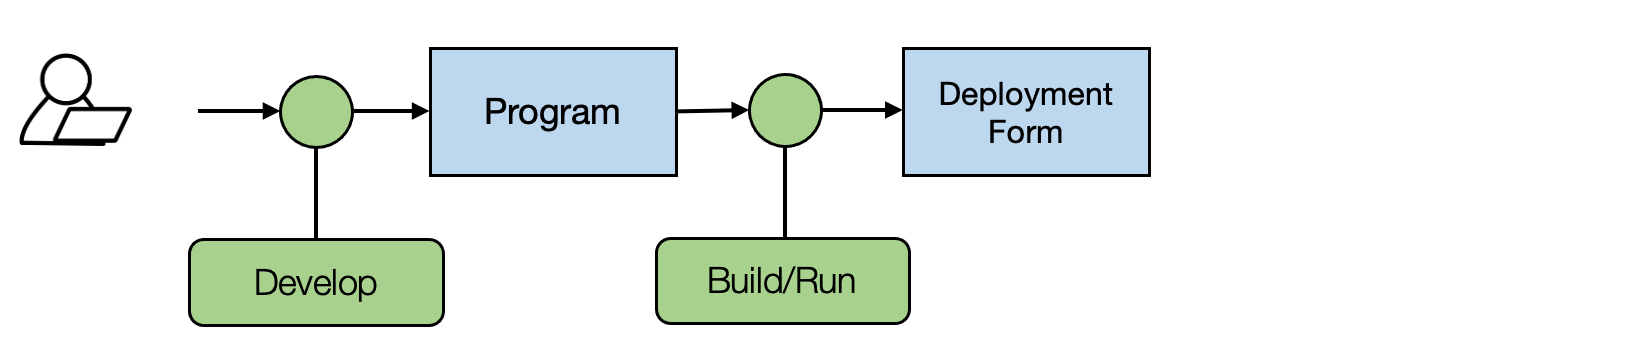

The above figure shows the standard development process. We need to repeat the process of developing different program variants and then (build if it is a compiled language) run them on the platform of interest.

The key difference in an MLC process(shown in the figure below) is the programmatic transformations among the IRModule (programs). So we can not only come up with program variants through development (either by manually writing the code or generating the code), but also can obtain variants by transforming the tensor programs.

Transformation is a very powerful tool that helps us simplify development costs and introduce more automation to the process. This section covered a specific perspective on primitive tensor functions via TensorIR, and we will cover more perspectives in the future.

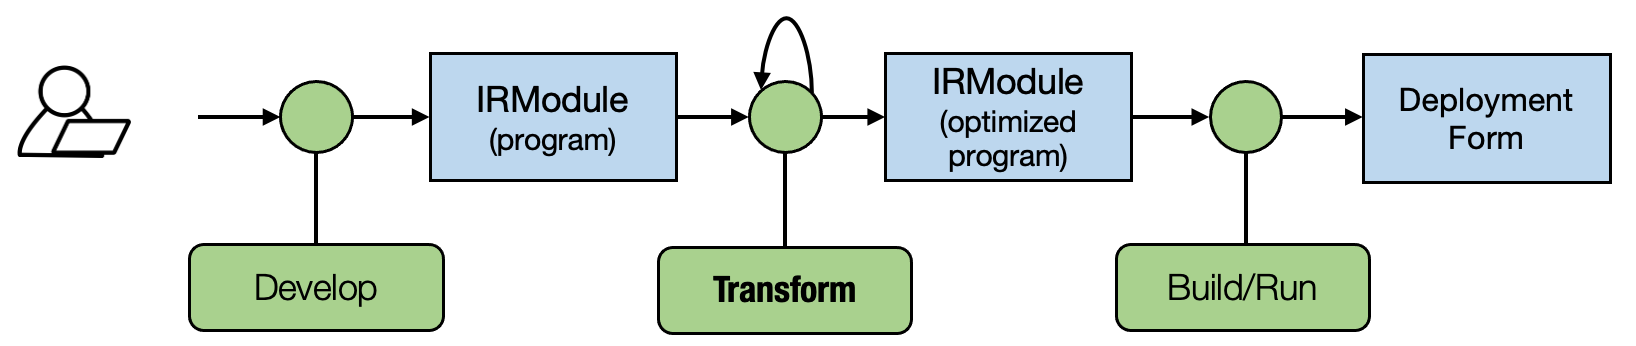

Notably, direct code development and transformations are equally important in practice: We can still leverage a lot of domain expertise to develop and optimize part of the programs and then combine that with transformation-based approaches. We will talk about how to combine the two practices in future chapters.
